#### Imports and session

In [29]:
!pip install pyspark
import pyspark 
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import ArrayType, StringType
from pyspark import broadcast
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats
import seaborn as sns
import sklearn

spark = SparkSession.builder \
    .master('local[*]') \
    .appName('BigData-HW') \
    .getOrCreate()


#### Get data

In [2]:
field_players = spark.read.csv('field_players.csv', header=True)
goalkeepers = spark.read.csv('goalkeepers.csv', header=True)
clubs = spark.read.csv('res_clubs.csv', header=True)


In [3]:
field_players.show(5)
field_players.printSchema()

+---+-----------+------+------+---+---------+----------+-----------+-----------+--------------------+-------+-----+---------+------+-----------+------------+---------+--------------+
|_c0|Tournaments|Weight|Height|Age|     Club|  Position|Nationality|Subscribers|                Name|Matches|Goals|Penalties|Passes|Goal+Passes|Yellow Cards|Red Cards|Avg_min_played|
+---+-----------+------+------+---+---------+----------+-----------+-----------+--------------------+-------+-----+---------+------+-----------+------------+---------+--------------+
|  0|       10.0|    72|   170| 33|Барселона|Нападающий|  Аргентина|     352455| Lionel Andrés Messi|    838|  694|     89.0| 246.0|      937.0|        86.0|      2.0|          80.0|
|  1|       19.0|    84|   187| 36|  Ювентус|Нападающий| Португалия|     347040|Cristiano Ronaldo...|    900|  721|    131.0| 170.0|      891.0|       118.0|     11.0|          83.0|
|  2|       19.0|    68|   175| 29|      ПСЖ|Нападающий|   Бразилия|     210888|Neyma

In [4]:
goalkeepers.show(5)
goalkeepers.printSchema()

+---+-----------+------+------+---+-----------------+--------+-----------+-----------+--------------------+-------+-----+---------+------+------------+---------+--------------+-----------+----+-----+------+--------------+
|_c0|Tournaments|Weight|Height|Age|             Club|Position|Nationality|Subscribers|                Name|Matches|Goals|Penalties|Passes|Yellow Cards|Red Cards|Conceded Goals|Dry matches|Wins|Draws|Losses|Avg_min_played|
+---+-----------+------+------+---+-----------------+--------+-----------+-----------+--------------------+-------+-----+---------+------+------------+---------+--------------+-----------+----+-----+------+--------------+
|  0|         11|    82|   186| 35|             ЦСКА| Вратарь|     Россия|     118336|       Igor Akinfeev|    549|    0|        0|     1|          31|        1|           514|        217| 299|  107|   142|            90|
|  1|         15|    92|   192| 43|          Ювентус| Вратарь|     Италия|       5554|    Gianluigi Buffon|    5

In [5]:
clubs.show(5)
clubs.printSchema()

+---------+--------------------+---------------+----+----+---+---+---+---+---+---+---+---+
|     Club|              League|          Игрок|   М| Мин|  З|ВнЗ|  Г|Пен|  П|Г+П| ЖК| КК|
+---------+--------------------+---------------+----+----+---+---+---+---+---+---+---+---+
|Барселона|Испания. Ла Лига ...|          Педри|36.0|2391| 21|  9|  3|  0|  3|  6|  2|  0|
|Барселона|Испания. Ла Лига ...| Френки де Йонг|36.0|3086|  5|  2|  3|  0|  4|  7|  5|  0|
|Барселона|Испания. Ла Лига ...|Антуан Гризманн|34.0|2463| 19|  4| 12|  1|  7| 19|  4|  0|
|Барселона|Испания. Ла Лига ...|  Лионель Месси|34.0|2934|  1|  2| 29|  3|  9| 38|  4|  0|
|Барселона|Испания. Ла Лига ...| Серджи Бускетс|34.0|2356| 19|  4|  0|  0|  4|  4|  8|  0|
+---------+--------------------+---------------+----+----+---+---+---+---+---+---+---+---+
only showing top 5 rows

root
 |-- Club: string (nullable = true)
 |-- League: string (nullable = true)
 |-- Игрок: string (nullable = true)
 |-- М: string (nullable = true)
 |-- Ми

In [6]:
from pyspark.sql.types import DoubleType
count_params = ['Tournaments', 'Weight', 'Height', 'Age', 'Subscribers', 'Matches', 'Goals', 'Penalties', 'Passes', 'Goal+Passes', 'Yellow Cards', 'Red Cards', 'Avg_min_played']
for param in count_params:
  field_players = field_players.withColumn(param, field_players[param].cast(DoubleType()))
field_players.describe(['Avg_min_played']).show()


+-------+------------------+
|summary|    Avg_min_played|
+-------+------------------+
|  count|             51972|
|   mean| 65.72304317709536|
| stddev|17.327318540917428|
|    min|               0.0|
|    max|             120.0|
+-------+------------------+



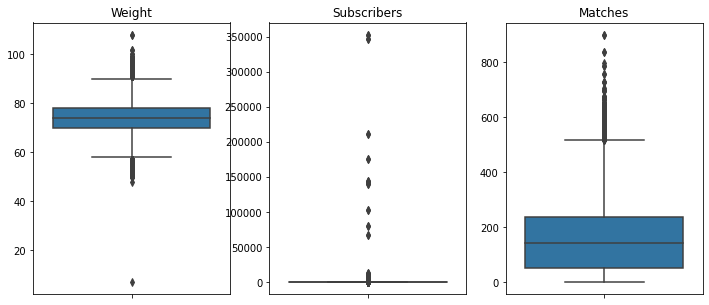

In [44]:
arr1 = np.array(field_players.select("Weight").collect())
arr2 = np.array(field_players.select("Subscribers").collect())
arr3 = np.array(field_players.select("Matches").collect())
arr4 = np.array(field_players[field_players.Matches > 100][field_players.Position != "Защитник"].select("Goals").collect())
arr5 = np.array(field_players.select("Age").collect())
arr6 = np.array(field_players.select("Passes").collect())

plt.figure(figsize=(12, 5))
plt.subplot(1, 3, 1)
plt.title('Weight')
sns.boxplot(y=arr1)

plt.subplot(1, 3, 2)
plt.title('Subscribers')
sns.boxplot(y=arr2)

plt.subplot(1, 3, 3)
plt.title('Matches')
sns.boxplot(y=arr3)

plt.show()

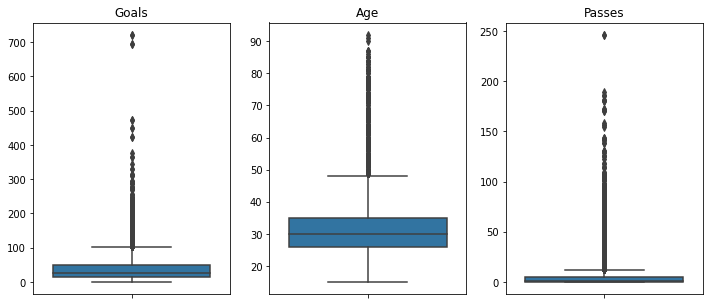

In [45]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 3, 1)
plt.title('Goals')
sns.boxplot(y=arr4)

plt.subplot(1, 3, 2)
plt.title('Age')
sns.boxplot(y=arr5)

plt.subplot(1, 3, 3)
plt.title('Passes')
sns.boxplot(y=arr6)

In [7]:
count_params = ['Tournaments', 'Weight', 'Height', 'Age', 'Subscribers', 'Matches', 'Goals', 'Penalties', 
                'Passes', 'Conceded Goals', 'Dry matches', 'Wins', 'Draws', 'Losses',
                'Yellow Cards', 'Red Cards', 'Avg_min_played']
for param in count_params:
  goalkeepers = goalkeepers.withColumn(param, goalkeepers[param].cast(DoubleType()))
goalkeepers.describe(['Avg_min_played']).show()

+-------+-----------------+
|summary|   Avg_min_played|
+-------+-----------------+
|  count|             5878|
|   mean|86.75416808438244|
| stddev|9.236202203951416|
|    min|              1.0|
|    max|            120.0|
+-------+-----------------+



In [8]:
field_players.filter(field_players['Name'].isNull()).count()

104

In [9]:
print(field_players.count())
field_players = field_players.filter((field_players.Name != 'null'))
print(field_players.count())
field_players = field_players.na.drop()
print(field_players.count())

field_players.show()

51997
51893
33030
+---+-----------+------+------+----+-----------------+------------+---------------+-----------+--------------------+-------+-----+---------+------+-----------+------------+---------+--------------+
|_c0|Tournaments|Weight|Height| Age|             Club|    Position|    Nationality|Subscribers|                Name|Matches|Goals|Penalties|Passes|Goal+Passes|Yellow Cards|Red Cards|Avg_min_played|
+---+-----------+------+------+----+-----------------+------------+---------------+-----------+--------------------+-------+-----+---------+------+-----------+------------+---------+--------------+
|  0|       10.0|  72.0| 170.0|33.0|        Барселона|  Нападающий|      Аргентина|   352455.0| Lionel Andrés Messi|  838.0|694.0|     89.0| 246.0|      937.0|        86.0|      2.0|          80.0|
|  1|       19.0|  84.0| 187.0|36.0|          Ювентус|  Нападающий|     Португалия|   347040.0|Cristiano Ronaldo...|  900.0|721.0|    131.0| 170.0|      891.0|       118.0|     11.0|        

In [10]:
import pyspark.sql.functions as F
sorted_field_players = field_players[field_players.Age <= 21][field_players.Age >= 16][field_players.Matches >= 40]
sorted_field_players = sorted_field_players.withColumn("GPM", F.col("Goals")/F.col("Matches"))
grouped = sorted_field_players.sort('GPM', ascending = False).select("Weight","Height", "Age", "Club", 
                                                                     "Position","Nationality", "Subscribers", "Name", 
                                                                     "Matches", "Goals", "Avg_min_played", "GPM")
grouped.show()

+------+------+----+-------------+------------+--------------------+-----------+--------------------+-------+-----+--------------+-------------------+
|Weight|Height| Age|         Club|    Position|         Nationality|Subscribers|                Name|Matches|Goals|Avg_min_played|                GPM|
+------+------+----+-------------+------------+--------------------+-----------+--------------------+-------+-----+--------------+-------------------+
|  87.0| 194.0|20.0|   Боруссия Д|  Нападающий|            Норвегия|     1924.0|       Erling Håland|  163.0|112.0|          64.0| 0.6871165644171779|
|  75.0| 176.0|21.0|Ди Си Юнайтед|  Нападающий|             Эстония|       11.0|          Erik Sorga|  163.0| 91.0|          59.0|  0.558282208588957|
|  63.0| 178.0|19.0|         Ланс|  Нападающий|             Франция|        9.0|Arnaud Kalimuendo...|   43.0| 22.0|          56.0| 0.5116279069767442|
|  69.0| 179.0|19.0| Динамо Минск|  Нападающий|            Беларусь|        3.0|   Vladislav L

In [11]:
import matplotlib.pyplot as plt

# field_players.groupBy('Nationality').count().orderBy("count", ascending=False).show()

def plot_param_occurence(data, param, top_limit=10):
  nations_count = data.filter((data[param] != 'None'))

  nations_count = nations_count.groupBy(param).count().orderBy("count", ascending=False).limit(top_limit)
  nations_count.show()

  total_nations = nations_count.groupBy().sum().collect()[0][0]
  nations_count = nations_count.toPandas()

  # Compute the percentage of top 5 workout type / total users
  nations_count['percentage'] = nations_count['count'] \
      / total_nations * 100


  fig, axs = plt.subplots(nrows=1, ncols=2, figsize=plt.figaspect(0.35))

  plot0 =   axs[0].bar(x=nations_count[param]
                      , height=nations_count['count'])
  title0 =  axs[0].set_title(param, fontsize = 'small')
  xlabel0 = axs[0].set_xlabel(param, fontsize = 'small')
  ylabel0 = axs[0].set_ylabel('{} count'.format(param), fontsize = 'small')
  xsticks_label = axs[0].set_xticklabels(nations_count[param] 
                                        ,rotation = 'vertical', fontsize='small')
  explode = [0.1 for i in range(top_limit)]
  title1 = axs[1].set_title('Top {}'.format(top_limit), fontsize = 'small')
  plot1 = axs[1].pie(
        x=nations_count['percentage']
      , labels=nations_count[param]
      , autopct='%1.1f%%', shadow=True, explode=explode, startangle=90
      , radius=1
  )

  text = fig.text(0.5, 1.02, 'Top {} {}'.format(top_limit, param), ha='center', va='top', transform=fig.transFigure)

+-----------+-----+
|Nationality|count|
+-----------+-----+
|     Россия| 3697|
|  Аргентина| 1921|
|    Испания| 1802|
|   Бразилия| 1594|
|     Англия| 1458|
|    Франция| 1287|
| Португалия| 1102|
|    Мексика| 1088|
|   Германия|  973|
|     Италия|  953|
+-----------+-----+



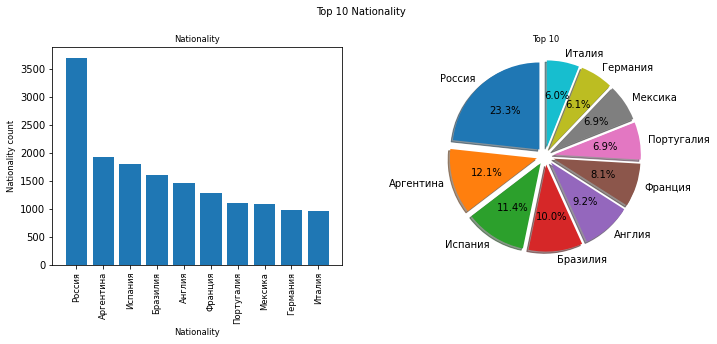

In [12]:
plot_param_occurence(field_players, 'Nationality')

In [13]:
fieldplayers1 = field_players[field_players.Height >= 190].select("Position", "Height")
goalkeepers1 = goalkeepers[goalkeepers.Height >= 190].select("Position", "Height")
all_players = fieldplayers1.union(goalkeepers1)

+------------+-----+
|    Position|count|
+------------+-----+
|     Вратарь| 2015|
|    Защитник| 1384|
|  Нападающий|  644|
|Полузащитник|  315|
+------------+-----+



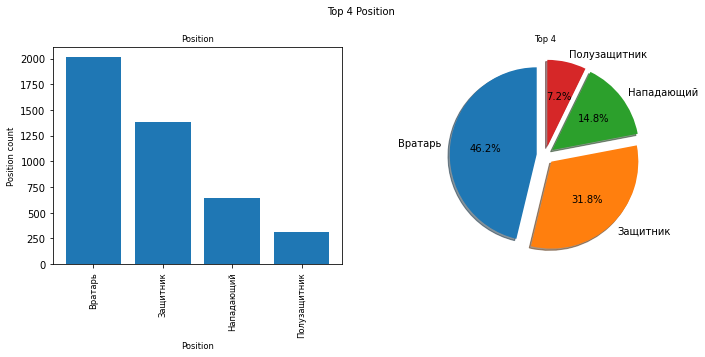

In [14]:
plot_param_occurence(all_players, 'Position', top_limit=4)

+-----------+-----+
|Nationality|count|
+-----------+-----+
|     Россия|  435|
|   Германия|  285|
|    Испания|  278|
|     Англия|  246|
|  Аргентина|  228|
|     Италия|  225|
|   Бразилия|  217|
|    Франция|  216|
|    Украина|  190|
|     Турция|  151|
+-----------+-----+



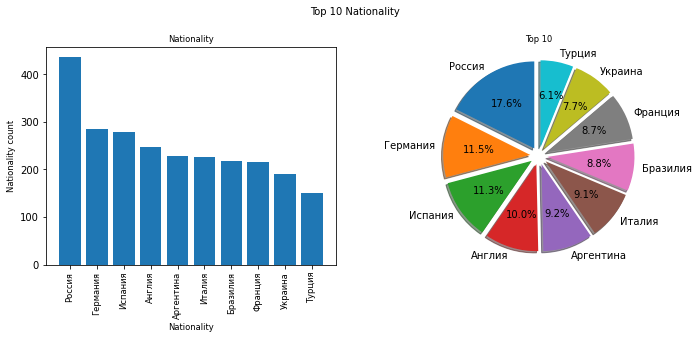

In [15]:
plot_param_occurence(goalkeepers, 'Nationality')

+-----------------+-----+
|             Club|count|
+-----------------+-----+
|      Реал Мадрид|   16|
|        Барселона|    9|
|        Ливерпуль|    8|
|   Манчестер Сити|    6|
|          Ювентус|    4|
|              ПСЖ|    4|
|Манчестер Юнайтед|    4|
|        Тоттенхэм|    4|
|        Локомотив|    4|
|          Бавария|    3|
+-----------------+-----+



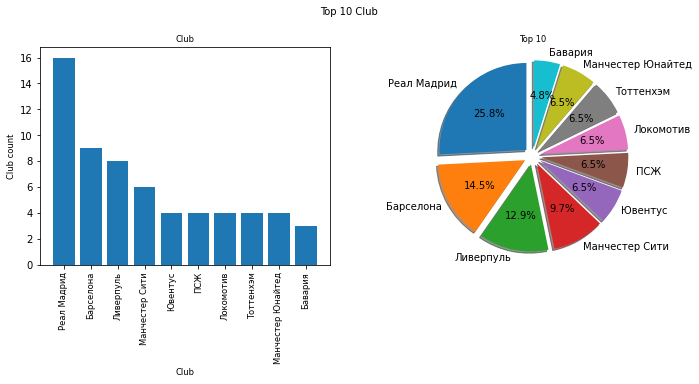

In [16]:
plot_param_occurence(field_players.limit(100), 'Club', top_limit=10)

+-----------------+-----+
|             Club|count|
+-----------------+-----+
|Манчестер Юнайтед|    4|
|             ЦСКА|    3|
|          Ювентус|    3|
|        Барселона|    3|
|            Челси|    3|
|          Бавария|    2|
|      Реал Мадрид|    2|
|        Ливерпуль|    2|
|            Зенит|    2|
|          Спартак|    2|
+-----------------+-----+



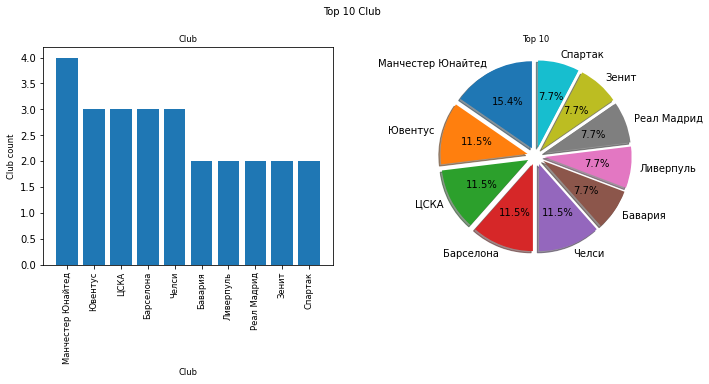

In [17]:
plot_param_occurence(goalkeepers.limit(100), 'Club')

+------------+-----+
|    Position|count|
+------------+-----+
|Полузащитник|14465|
|    Защитник|11406|
|  Нападающий| 7159|
+------------+-----+



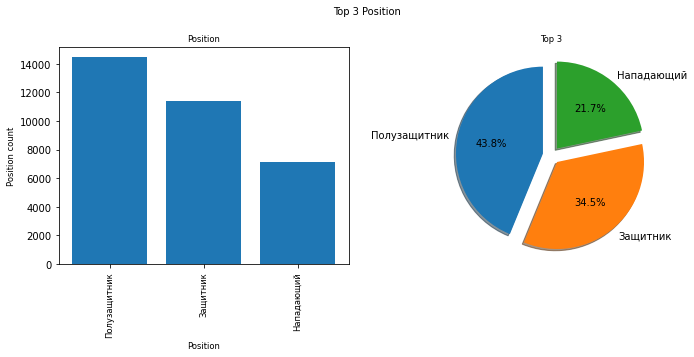

In [18]:
plot_param_occurence(field_players, 'Position', top_limit=3)

+-----------------+-----+
|             Club|count|
+-----------------+-----+
|      Реал Мадрид|   16|
|        Барселона|    9|
|        Ливерпуль|    8|
|   Манчестер Сити|    6|
|          Ювентус|    4|
|              ПСЖ|    4|
|Манчестер Юнайтед|    4|
|        Тоттенхэм|    4|
|        Локомотив|    4|
|          Бавария|    3|
+-----------------+-----+



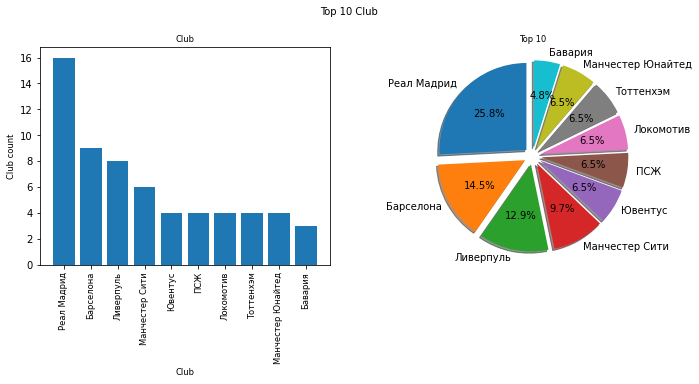

In [19]:
top_50 = field_players.limit(100)

plot_param_occurence(top_50, 'Club', top_limit=10)

In [20]:
from pyspark.sql.functions import mean as _mean, stddev as _stddev, col

df_stats = clubs.select(
    _mean(col('ВнЗ')).alias('mean'),
    _stddev(col('ВнЗ')).alias('std')
).collect()

mean = df_stats[0]['mean']
std = df_stats[0]['std']
mean

6.540924309735581

In [21]:
count_params = ['М', 'Мин', 'З', 'ВнЗ', 
                'Г', 'Пен', 'П', 'Г+П', 'ЖК',
                'КК']

for param in count_params:
  clubs = clubs.withColumn(param, clubs[param].cast(DoubleType()))

In [23]:
sorted_clubs = clubs[clubs.Игрок != "Всего"][clubs.League != "Беларусь. Кубок 2021"][clubs.ВнЗ >= 15 ]
grouped = sorted_clubs.groupBy('Club').count().sort('count', ascending = False)
grouped.show()

+------------------+-----+
|              Club|count|
+------------------+-----+
|           Барнсли|   32|
|         Брентфорд|   27|
|           Клермон|   27|
|       Реал Мадрид|   26|
|          Атлетико|   25|
|           Престон|   25|
|   Оксфорд Юнайтед|   25|
|            Наполи|   24|
|          Миллуолл|   23|
|          Тенерифе|   23|
|           Севилья|   22|
|        Вильярреал|   22|
|             Лацио|   21|
|            Эмполи|   21|
|Алания Владикавказ|   20|
|          Валенсия|   20|
|             Лилль|   20|
|         Тоттенхэм|   20|
|            Рединг|   20|
|            Шинник|   19|
+------------------+-----+
only showing top 20 rows



In [24]:
clubs_pen = clubs[clubs.Игрок != "Всего"].groupBy('Club').count().sort('count', ascending = False)
clubs_pen.show()

+--------------------+-----+
|                Club|count|
+--------------------+-----+
|    Реал Мадрид U-19|  981|
|Атлетико Мадрид U-19|  899|
|        Ювентус U-19|  834|
|        Бенфика U-19|  825|
|           Аякс U-19|  806|
|      Барселона U-19|  786|
|            ПСЖ U-19|  756|
|        Бавария U-19|  745|
|          Порту U-19|  715|
|         Гвадалахара|  644|
|Боруссия Дортмунд...|  630|
| Манчестер Сити U-19|  628|
|  Атлетико Насьональ|  626|
|        Бока Хуниорс|  623|
|      Велес Сарсфилд|  611|
|           Тоттенхэм|  586|
|   Манчестер Юнайтед|  581|
|             Арсенал|  580|
|   Расинг Авельянеда|  574|
|             Америка|  571|
+--------------------+-----+
only showing top 20 rows



In [26]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import MinMaxScaler
from pyspark.ml import Pipeline

ignore=['Club', 'Position','_c0', 'Nationality', 'Name', 'Goals', 'Goal+Passes', "Tournaments", "Weight", "Height", "Age", "Subscribers", "Matches", "Penalties", 
        "Passes", "Yellow Cards", "Red Cards", "Avg_min_played", 'Tournaments_vec', 'Weight_vec', 'Height_vec', 'Age_vec', 'Subscribers_vec', 'Matches_vec',
        'Penalties_vec','Passes_vec','Yellow Cards_vec', 'Red Cards_vec', 'Avg_min_played_vec']

indexer = StringIndexer(inputCol="Nationality", outputCol="Nationality1") 
indexed = indexer.fit(field_players).transform(field_players) 

indexer = StringIndexer(inputCol="Position", outputCol="Position1") 
indexed2 = indexer.fit(indexed).transform(indexed) 

scaler = MinMaxScaler(inputCol="x_vec", outputCol="x_scaled")
columns_to_scale = ["Tournaments", "Weight", "Height", "Age", "Subscribers", "Matches", "Penalties", "Passes", "Yellow Cards", "Red Cards", "Avg_min_played"]

assemblers = [VectorAssembler(inputCols=[col], outputCol=col + "_vec") for col in columns_to_scale]
scalers = [MinMaxScaler(inputCol=col + "_vec", outputCol=col + "_scaled") for col in columns_to_scale]
pipeline = Pipeline(stages=assemblers + scalers)
scalerModel = pipeline.fit(indexed2)
scaledData = scalerModel.transform(indexed2)

vectorAssembler = VectorAssembler(inputCols=[x for x in scaledData.columns if x not in ignore], outputCol = 'features')
new_df = vectorAssembler.transform(scaledData)

# new_df = new_df.select(['features', 'Goals'])
new_df.show()

train, test = new_df.randomSplit([0.75, 0.25], seed = 218)

from pyspark.ml.regression import LinearRegression

lr = LinearRegression(featuresCol = 'features', 
                         labelCol='Goals')
lr_model = lr.fit(train)

+---+-----------+------+------+----+-----------------+------------+---------------+-----------+--------------------+-------+-----+---------+------+-----------+------------+---------+--------------+------------+---------+---------------+----------+----------+-------+---------------+-----------+-------------+----------+----------------+-------------+------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+---------------------+--------------------+
|_c0|Tournaments|Weight|Height| Age|             Club|    Position|    Nationality|Subscribers|                Name|Matches|Goals|Penalties|Passes|Goal+Passes|Yellow Cards|Red Cards|Avg_min_played|Nationality1|Position1|Tournaments_vec|Weight_vec|Height_vec|Age_vec|Subscribers_vec|Matches_vec|Penalties_vec|Passes_vec|Yellow Cards_vec|Red Cards_vec|Avg_min_played_vec|  Tourna

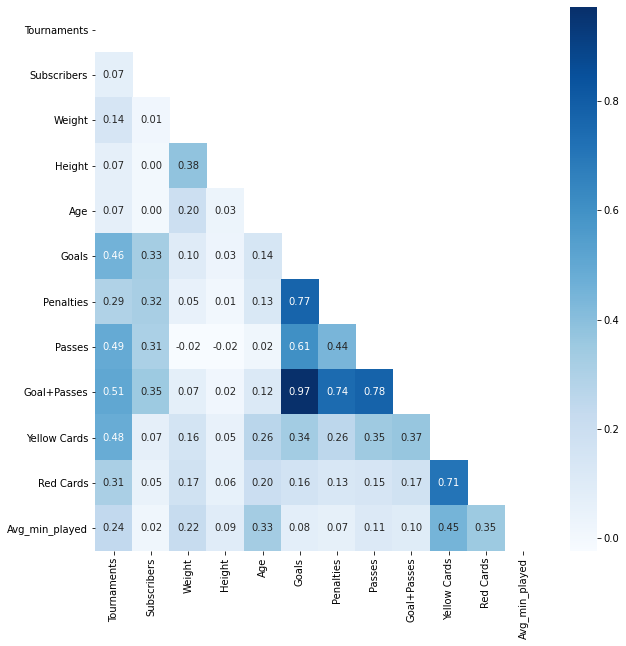

In [30]:
# Building a correlation matrix of features
pandas_field_players = field_players.toPandas()
X = pandas_field_players.loc[:, ['Tournaments', 'Subscribers', 'Weight', 'Height', 'Age', 
                      'Goals','Penalties', 'Passes', 'Goal+Passes', 
                      'Yellow Cards', 'Red Cards', 'Avg_min_played', ]]

dataset = X
corr = dataset.corr()

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True


f, ax = plt.subplots(figsize=(10, 10))

sns.heatmap(corr, mask = mask, annot=True, fmt= '.2f', ax = ax, cmap = 'Blues')

In [31]:
trainingSummary = lr_model.summary
print("numIterations: %d" % trainingSummary.totalIterations)
print("objectiveHistory: %s" % str(trainingSummary.objectiveHistory))
trainingSummary.residuals.show()
print("RMSE: %f" % trainingSummary.rootMeanSquaredError)
print("r2: %f" % trainingSummary.r2)

numIterations: 0
objectiveHistory: [0.0]
+-------------------+
|          residuals|
+-------------------+
|  36.70609467851159|
| -44.04857539551699|
|  61.18804050827708|
| -3.880660798133924|
|  15.45234046758862|
|-31.292233692880274|
|-11.512136636886439|
| -18.07618842123634|
| -2.498154912466717|
| -7.456402578210485|
|-1.0788691786240605|
|-1.7628715996016098|
| 1.8056501598553134|
| -4.547155844857736|
| 2.6160317200198335|
| 2.6356197098262495|
|  -6.21214179355708|
|-13.304424917386214|
| 13.987371552003015|
| -9.539792321862492|
+-------------------+
only showing top 20 rows

RMSE: 13.755471
r2: 0.781328


In [32]:
# test_col = [6, 2, 19, 84, 187, 36, 347040, 900, 131.0, 170.0, 118.0, 11.0, 83.0]
lr_predictions = lr_model.transform(test)
lr_predictions.select("features").show(5)
from pyspark.ml.evaluation import RegressionEvaluator
lr_evaluator = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="Goals",metricName="r2")
print("R Squared (R2) on test data = %g" % lr_evaluator.evaluate(lr_predictions))

+--------------------+
|            features|
+--------------------+
|[12.0,2.0,0.26086...|
|[12.0,0.0,0.13043...|
|[1.0,2.0,0.173913...|
|[6.0,1.0,0.826086...|
|[1.0,1.0,0.130434...|
+--------------------+
only showing top 5 rows

R Squared (R2) on test data = 0.784307


In [33]:
lr_predictions[lr_predictions.Goals >= 200].select("Name", "Goals", "prediction").sort("Goals", ascending=False).show(20)

+--------------------+-----+------------------+
|                Name|Goals|        prediction|
+--------------------+-----+------------------+
|Cristiano Ronaldo...|721.0|  765.048575395517|
|  Zlatan Ibrahimovic|450.0| 457.7176462457302|
|Luis Alberto Suár...|423.0|  333.604107117154|
|Edinson Roberto C...|377.0| 266.1629368176951|
| André-Pierre Gignac|248.0| 149.1595839786345|
|   Antoine Griezmann|243.0| 157.1743966238048|
|      Olivier Giroud|239.0|155.55216391535586|
|       Ciro Immobile|238.0|230.35075338574407|
|Jonas Gonçalves O...|221.0|167.61804974975345|
|Carlos Arturo Bac...|212.0|168.33182266742276|
|       Luuk  de Jong|206.0|131.23483802492584|
| Alexandre Lacazette|205.0|176.50944627428495|
+--------------------+-----+------------------+



In [34]:
lr_model.summary.r2

0.7813276797978395

[[52.]
 [59.]
 [64.]
 ...
 [ 0.]
 [25.]
 [ 0.]]


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


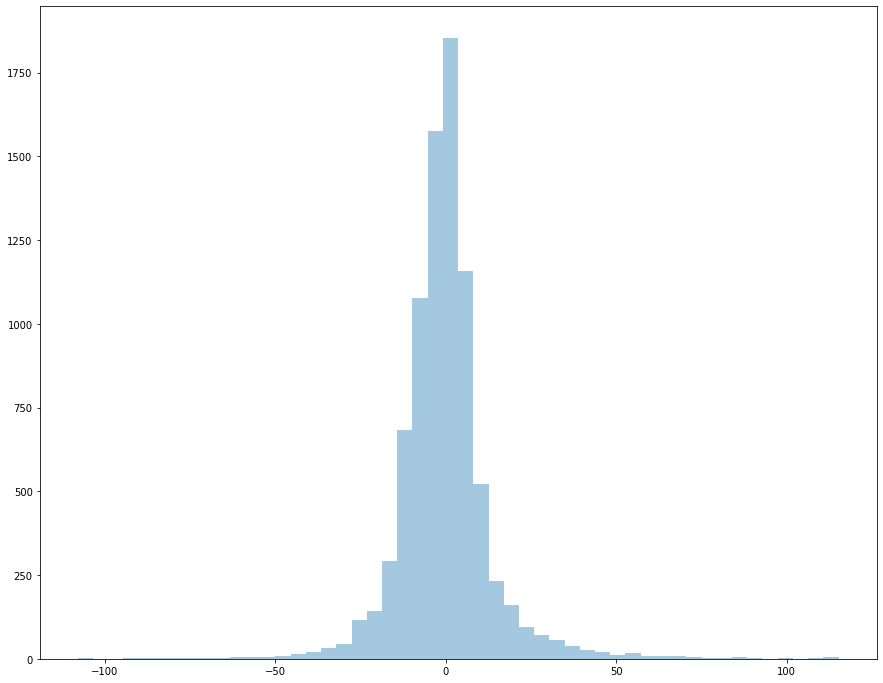

In [35]:
# Plotting the distribution of residuals
plt.figure(figsize=(15, 12))
y_pred_all = np.array(lr_predictions.select("prediction").collect())
y1 = np.array(lr_predictions.select("Goals").collect())
y2 = np.array(y_pred_all)
y_diff = y1 - y2
print(y1)
sns.distplot(y_diff, kde=False)